In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix

In [2]:
train = pd.read_csv('../data/new_train.csv')
test = pd.read_csv('../data/new_test.csv')
mcf = pd.read_csv('../data/monthly_card_features.csv')

In [3]:
train = train.drop(columns=['Unnamed: 0', 'first_active_month']).set_index('card_id')
test = test.drop(columns=['Unnamed: 0', 'first_active_month']).set_index('card_id')

In [4]:
train = train.join(mcf.groupby('card_id').agg({
    'amt_total': [np.min, np.mean, np.max],
    'NDR':       [np.min, np.mean, np.max],
    'n_new_merchants':   np.mean,
    'n_total_merchants': np.max
}))
test = test.join(mcf.groupby('card_id').agg({
    'amt_total': [np.min, np.mean, np.max],
    'NDR':       [np.min, np.mean, np.max],
    'n_new_merchants':   np.mean,
    'n_total_merchants': np.max
}))

/Users/michaelfedell/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/Users/michaelfedell/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [5]:
train.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in train.columns.values]
test.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in test.columns.values]

In [6]:
X = train.drop(columns='target')
X.columns

Index(['feature_1', 'feature_2', 'feature_3', 'tof', 'recency', 'frequency',
       'log_freq', 'amt', 'avg_amt', 'charge_per_day', 'log_charge_per_day',
       'max_amt', 'n_declines', 'log_n_declines', 'prop_new', 'merch_cat_1_Y',
       'merch_cat_2_1', 'merch_cat_2_2', 'merch_cat_2_3', 'merch_cat_2_4',
       'merch_cat_2_5', 'amt_total_amin', 'amt_total_mean', 'amt_total_amax',
       'NDR_amin', 'NDR_mean', 'NDR_amax', 'n_new_merchants_mean',
       'n_total_merchants_amax'],
      dtype='object')

In [7]:
Y = train['target']

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3)
X_val.shape

(60576, 29)

In [9]:
rfr = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)

In [10]:
rfr.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [11]:
print("Root Mean squared error: %.2f"
      % np.sqrt(mean_squared_error(Y_val, rfr.predict(X_val))))

Root Mean squared error: 3.75


## What if we bring in our chump-classifier?

In [12]:
train['chump'] = train['target'] < -20

In [13]:
chumps = train[train.chump]
nonchumps = train[~train.chump]

In [14]:
tr_chumps, tt_chumps = train_test_split(chumps, test_size=0.3)
tr_nonchumps, tt_nonchumps = train_test_split(nonchumps, test_size=0.3)

In [15]:
tr = pd.concat([tr_chumps, tr_nonchumps])
tt = pd.concat([tt_chumps, tt_nonchumps])
print('Training chumps:', sum(tr.chump)/len(tr))
print('Test chumps:    ', sum(tt.chump)/len(tt))

Training chumps: 0.010923935729901444
Test chumps:     0.010944928684627575


In [16]:
balanced = pd.concat([
    tr[tr.chump],
    tr[~tr.chump].sample(n=9 * len(tr[tr.chump]))
])
# Train on balanced data (10% chumps)
X = balanced.drop(columns=['chump', 'target'])
Y = balanced['chump']

In [17]:
print('Balanced chumps: ', sum(balanced.chump) / len(balanced))

Balanced chumps:  0.1


In [18]:
clf = RandomForestClassifier(n_estimators=100, max_depth=7)
clf.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Now retrain the regressor on only "non-chumps"

In [19]:
X = tr[~tr.chump].drop(columns=['chump', 'target'])
Y = tr[~tr.chump]['target']

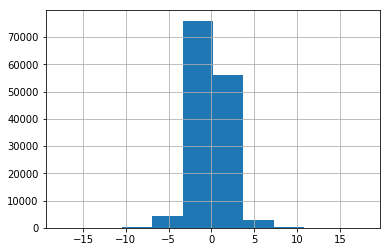

In [20]:
Y.hist()

In [21]:
rfr = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
rfr.fit(X, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

## Apply trained models to full train set

In [22]:
X = tt.drop(columns=['chump', 'target'])
Y = tt['target']

In [23]:
X['pred_chump'] = clf.predict(X)

In [24]:
chumps = pd.DataFrame(X[X.pred_chump])
nonchumps = pd.DataFrame(X[~X.pred_chump])
chumps.head()

,feature_1,feature_2,feature_3,tof,recency,frequency,log_freq,amt,avg_amt,charge_per_day,...,merch_cat_2_5,amt_total_amin,amt_total_mean,amt_total_amax,NDR_amin,NDR_mean,NDR_amax,n_new_merchants_mean,n_total_merchants_amax,pred_chump
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_5aa947629e,3,3,1,480,253,90,4.499810,-60.393730,-0.671041,0.187110,...,0,68.13,649.135714,1490.90,0.000000,0.625332,1.0,6.666667,40.0,True
C_ID_2883f8e44b,5,1,1,473,159,107,4.672829,-64.153694,-0.599567,0.225738,...,0,240.78,953.795455,2178.17,0.000000,0.458777,1.0,3.100000,31.0,True
C_ID_33b272076e,2,1,0,307,92,87,4.465908,-42.407536,-0.487443,0.282468,...,0,30.50,1877.801250,10896.32,0.000000,0.482835,1.0,2.285714,16.0,True
C_ID_ce58ebbf13,2,1,0,382,107,116,4.753590,-78.739688,-0.678790,0.302872,...,67,50.00,525.845000,1019.18,0.051899,0.666653,1.0,2.900000,29.0,True
C_ID_dbc32ca661,5,1,1,465,106,125,4.828314,-87.101837,-0.696815,0.268240,...,4,16.00,320.543077,607.67,0.000000,0.338693,1.0,3.333333,30.0,True


In [25]:
chumps['pred_target'] = -33.219281
chumps.head()

,feature_1,feature_2,feature_3,tof,recency,frequency,log_freq,amt,avg_amt,charge_per_day,...,amt_total_amin,amt_total_mean,amt_total_amax,NDR_amin,NDR_mean,NDR_amax,n_new_merchants_mean,n_total_merchants_amax,pred_chump,pred_target
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_5aa947629e,3,3,1,480,253,90,4.499810,-60.393730,-0.671041,0.187110,...,68.13,649.135714,1490.90,0.000000,0.625332,1.0,6.666667,40.0,True,-33.219281
C_ID_2883f8e44b,5,1,1,473,159,107,4.672829,-64.153694,-0.599567,0.225738,...,240.78,953.795455,2178.17,0.000000,0.458777,1.0,3.100000,31.0,True,-33.219281
C_ID_33b272076e,2,1,0,307,92,87,4.465908,-42.407536,-0.487443,0.282468,...,30.50,1877.801250,10896.32,0.000000,0.482835,1.0,2.285714,16.0,True,-33.219281
C_ID_ce58ebbf13,2,1,0,382,107,116,4.753590,-78.739688,-0.678790,0.302872,...,50.00,525.845000,1019.18,0.051899,0.666653,1.0,2.900000,29.0,True,-33.219281
C_ID_dbc32ca661,5,1,1,465,106,125,4.828314,-87.101837,-0.696815,0.268240,...,16.00,320.543077,607.67,0.000000,0.338693,1.0,3.333333,30.0,True,-33.219281


In [26]:
# X.loc[X.pred_chump, 'pred_target'] = -33.219281

In [27]:
X.head()

,feature_1,feature_2,feature_3,tof,recency,frequency,log_freq,amt,avg_amt,charge_per_day,...,merch_cat_2_5,amt_total_amin,amt_total_mean,amt_total_amax,NDR_amin,NDR_mean,NDR_amax,n_new_merchants_mean,n_total_merchants_amax,pred_chump
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_5aa947629e,3,3,1,480,253,90,4.499810,-60.393730,-0.671041,0.187110,...,0,68.13,649.135714,1490.90,0.000000,0.625332,1.0,6.666667,40.0,True
C_ID_02d39fcb5e,3,3,1,483,133,131,4.875197,-85.584114,-0.653314,0.270661,...,0,25.48,679.954167,1729.54,0.000000,0.587922,1.0,5.800000,58.0,False
C_ID_0b358310f5,2,1,0,469,103,286,5.655992,-177.357318,-0.620130,0.608511,...,0,131.67,1856.120000,5924.58,0.179768,0.638181,1.0,4.538462,59.0,False
C_ID_0594e296e2,3,3,1,480,73,10,2.302585,-5.026654,-0.502665,0.020790,...,1,29.99,270.901667,418.58,1.000000,1.000000,1.0,1.500000,9.0,False
C_ID_c2643d7c2c,5,1,1,478,357,28,3.332205,-18.396282,-0.657010,0.058455,...,0,262.97,335.026000,548.25,0.000000,0.238963,1.0,1.500000,3.0,False


In [28]:
nonchumps['pred_target'] = rfr.predict(nonchumps.drop(columns='pred_chump'))
nonchumps.head()

,feature_1,feature_2,feature_3,tof,recency,frequency,log_freq,amt,avg_amt,charge_per_day,...,amt_total_amin,amt_total_mean,amt_total_amax,NDR_amin,NDR_mean,NDR_amax,n_new_merchants_mean,n_total_merchants_amax,pred_chump,pred_target
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_02d39fcb5e,3,3,1,483,133,131,4.875197,-85.584114,-0.653314,0.270661,...,25.48,679.954167,1729.54,0.000000,0.587922,1.0,5.800000,58.0,False,1.309230
C_ID_0b358310f5,2,1,0,469,103,286,5.655992,-177.357318,-0.620130,0.608511,...,131.67,1856.120000,5924.58,0.179768,0.638181,1.0,4.538462,59.0,False,-0.636671
C_ID_0594e296e2,3,3,1,480,73,10,2.302585,-5.026654,-0.502665,0.020790,...,29.99,270.901667,418.58,1.000000,1.000000,1.0,1.500000,9.0,False,0.560914
C_ID_c2643d7c2c,5,1,1,478,357,28,3.332205,-18.396282,-0.657010,0.058455,...,262.97,335.026000,548.25,0.000000,0.238963,1.0,1.500000,3.0,False,0.310799
C_ID_f48fce5919,3,3,1,480,228,24,3.178054,-16.998772,-0.708282,0.049896,...,7.15,102.820000,207.74,0.701886,0.902105,1.0,2.833333,17.0,False,0.825034


In [29]:
# X.loc[~X.pred_chump, 'pred_target'] = rfr.predict(X[~X.pred_chump].drop(columns=['pred_chump', 'pred_target']))

In [30]:
X.head()

,feature_1,feature_2,feature_3,tof,recency,frequency,log_freq,amt,avg_amt,charge_per_day,...,merch_cat_2_5,amt_total_amin,amt_total_mean,amt_total_amax,NDR_amin,NDR_mean,NDR_amax,n_new_merchants_mean,n_total_merchants_amax,pred_chump
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_5aa947629e,3,3,1,480,253,90,4.499810,-60.393730,-0.671041,0.187110,...,0,68.13,649.135714,1490.90,0.000000,0.625332,1.0,6.666667,40.0,True
C_ID_02d39fcb5e,3,3,1,483,133,131,4.875197,-85.584114,-0.653314,0.270661,...,0,25.48,679.954167,1729.54,0.000000,0.587922,1.0,5.800000,58.0,False
C_ID_0b358310f5,2,1,0,469,103,286,5.655992,-177.357318,-0.620130,0.608511,...,0,131.67,1856.120000,5924.58,0.179768,0.638181,1.0,4.538462,59.0,False
C_ID_0594e296e2,3,3,1,480,73,10,2.302585,-5.026654,-0.502665,0.020790,...,1,29.99,270.901667,418.58,1.000000,1.000000,1.0,1.500000,9.0,False
C_ID_c2643d7c2c,5,1,1,478,357,28,3.332205,-18.396282,-0.657010,0.058455,...,0,262.97,335.026000,548.25,0.000000,0.238963,1.0,1.500000,3.0,False


In [31]:
X = pd.concat([chumps, nonchumps])
X = X.join(Y)

In [32]:
np.sqrt(mean_squared_error(X.target, X.pred_target))

4.006709273736031

In [33]:
len(X[X.pred_chump])

159

In [34]:
sum(X.target < -20)

663

In [35]:
sum(X.pred_chump != (X.target < -20))

734

In [36]:
# Split dataset into tr for training and tt for final test
# tr and tt will maintain the same chump/nonchump ratio
train['chump'] = train['target'] < -20
chumps = train[train.chump]
nonchumps = train[~train.chump]
tr_chumps, tt_chumps = train_test_split(chumps, test_size=0.3)
tr_nonchumps, tt_nonchumps = train_test_split(nonchumps, test_size=0.3)
tr = pd.concat([tr_chumps, tr_nonchumps])
tt = pd.concat([tt_chumps, tt_nonchumps])

ranges = [1, 3, 5, 7, 10, 15, None]
models = [
    {'rmd': rmd,
     'rmf': rmf,
     'cmd': cmd,
     'cmf': cmf,
     'score': np.nan} 
    for rmd in ranges
    for rmf in ranges
    for cmd in ranges
    for cmf in ranges
]

for i, m in enumerate(models):
    # Train Classifier (rebalanced tr set)
    balanced = pd.concat([
        tr[tr.chump],
        tr[~tr.chump].sample(n=9 * len(tr[tr.chump]))
    ])
    # Train on balanced data (10% chumps)
    X = balanced.drop(columns=['chump', 'target'])
    Y = balanced['chump']
    clf = RandomForestClassifier(
        n_estimators=  100,
        max_depth=     m['cmd'],
        max_features=  m['cmf'],
        random_state=  0)
    clf.fit(X, Y)
    
    # Train Regressor (full tr set)
    X = tr[~tr.chump].drop(columns=['chump', 'target'])
    Y = tr[~tr.chump]['target']
    rfr = RandomForestRegressor(
        n_estimators=  100,
        max_depth=     m['rmd'],
        max_features=  m['rmf'],
        random_state=  0)
    rfr.fit(X, Y)
    
    # Apply models to tt holdout set
    X = tt.drop(columns=['chump', 'target'])
    Y = tt['target']
    X['pred_chump'] = clf.predict(X)
    chumps = pd.DataFrame(X[X.pred_chump])
    nonchumps = pd.DataFrame(X[~X.pred_chump])
    chumps['pred_target'] = -33.219281
    nonchumps['pred_target'] = rfr.predict(nonchumps.drop(columns='pred_chump'))
    X = pd.concat([chumps, nonchumps])
    X = X.join(Y)
    m['score'] = np.sqrt(mean_squared_error(X.target, X.pred_target))
    print(f'== {np.round((i + 1) / len(models) * 100, 2)}% ==\r', end='')

KeyboardInterrupt: 

In [ ]:
sorted(models, key = lambda x: x['score'])[:15]

In [38]:
train['chump'] = train['target'] < -20
# Train Classifier (rebalanced tr set)
balanced = pd.concat([
    train[train.chump],
    train[~train.chump].sample(n=9 * len(train[train.chump]))
])
# Train on balanced data (10% chumps)
X = balanced.drop(columns=['chump', 'target'])
Y = balanced['chump']
clf = RandomForestClassifier(
    n_estimators=  1000,
    max_depth=     3,
    max_features=  3,
    random_state=  0)
clf.fit(X, Y)

# Train Regressor (full tr set)
X = train[~train.chump].drop(columns=['chump', 'target'])
Y = train[~train.chump]['target']
rfr = RandomForestRegressor(
    n_estimators=  1000,
    max_depth=     10,
    max_features=  15,
    random_state=  0)
rfr.fit(X, Y)

# Apply models to tt holdout set
test['pred_chump'] = clf.predict(test)
chumps = pd.DataFrame(test[test.pred_chump])
nonchumps = pd.DataFrame(test[~test.pred_chump])
chumps['pred_target'] = -33.219281
nonchumps['pred_target'] = rfr.predict(nonchumps.drop(columns='pred_chump'))
test = pd.concat([chumps, nonchumps])
predictions = pd.DataFrame(test['pred_target'], index=test.index)
predictions.head()

,pred_target
card_id,
C_ID_0ab67a22ab,-0.272179
C_ID_130fd0cbdd,-0.450876
C_ID_b709037bc5,0.002175
C_ID_d27d835a9f,-0.293506
C_ID_2b5e3df5c2,-0.209106


In [39]:
predictions = pd.DataFrame(test['pred_target'], index=test.index)
predictions.columns = ['target']
predictions.head()

,target
card_id,
C_ID_0ab67a22ab,-0.272179
C_ID_130fd0cbdd,-0.450876
C_ID_b709037bc5,0.002175
C_ID_d27d835a9f,-0.293506
C_ID_2b5e3df5c2,-0.209106


In [40]:
predictions.to_csv('../submission_stacked_rf.csv')

# Forget the stacked model - tune RFR to full training data

In [ ]:
train['chump'] = train['target'] < -20
chumps = train[train.chump]
nonchumps = train[~train.chump]
tr_chumps, tt_chumps = train_test_split(chumps, test_size=0.3)
tr_nonchumps, tt_nonchumps = train_test_split(nonchumps, test_size=0.3)
tr = pd.concat([tr_chumps, tr_nonchumps]).drop(columns='chump')
tt = pd.concat([tt_chumps, tt_nonchumps]).drop(columns='chump')

ranges = [1, 3, 5, 7, 10, 15, None]
models = [
    {'rmd': rmd,
     'rmf': rmf,
     'score': np.nan} 
    for rmd in ranges
    for rmf in ranges
]

for i, m in enumerate(models):
    X = tr.drop(columns='target')
    Y = tr['target']
    rfr = RandomForestRegressor(
        n_estimators=  100,
        max_depth=     m['rmd'],
        max_features=  m['rmf'],
        random_state=  0)
    rfr.fit(X, Y)
    
    # Apply models to tt holdout set
    X = tt.drop(columns='target')
    Y = tt['target']
    X['pred_target'] = rfr.predict(X)
    X = X.join(Y)
    m['score'] = np.sqrt(mean_squared_error(X.target, X.pred_target))
    print(f'== {np.round((i + 1) / len(models) * 100, 2)}% ==\r', end='')

In [ ]:
sorted(models, key = lambda x: x['score'])[:15]

In [ ]:
test.columns

### Best model has `max_depth=10` and `max_features=15`

In [41]:
X = train.drop(columns=['target', 'chump'])
Y = train['target']
rfr = RandomForestRegressor(
        n_estimators=  1000,
        max_depth=     10,
        max_features=  15,
        random_state=  0)
rfr.fit(X, Y)
pd.DataFrame(rfr.predict(test), index=test.index, columns='target').head()

ValueError: Number of features of the model must match the input. Model n_features is 29 and input n_features is 31 

In [ ]:
feature_imp = pd.Series(rfr.feature_importances_,index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp.head(10), y=feature_imp.index[:10])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
predictions = pd.DataFrame(rfr.predict(test), index=test.index, columns=['target'])
predictions.head()

In [ ]:
predictions.to_csv('../submission.csv')

In [ ]:
print(
    np.mean(train[train.target > -20].target), ',',
    np.std(train[train.target > -20].target)
)

In [ ]:
train.columns